In [1]:
import os, sys
parent_dir = os.path.realpath('..')
sys.path.append(parent_dir)

In [2]:
import argparse
import logging
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from src.libs.train_valid_test_utils import TrainValidEvaluate

import matplotlib.pyplot as plt

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

In [4]:
np.random.seed(42)

# Data

## data analysis

In [5]:
parent_dir

'/Users/a11910/Documents/42dot/accidentdetection_lv2'

In [8]:
data = pd.read_csv(f'{parent_dir}/data/processed/6dof/6dof_F_uniform_input.csv')
data

,Unnamed: 0,Fx,Fy,Fz,Mx,My,Mz,rx,ry,rz,...,vz,wx,wy,wz,e1,e2,e3,dvx,dvy,dvz
0,0,-0.267103,-0.202699,0.770637,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.0,0.0,0.0,0.1,0.2,0.3,-0.267103,-0.202699,0.770637
1,1,-0.783751,0.452041,-0.751070,0.0,0.0,0.0,-8.086109e-08,-2.338268e-07,1.216049e-07,...,-0.000032,0.0,0.0,0.0,0.1,0.2,0.3,-0.783751,0.452041,-0.751070
2,2,0.516694,-0.699261,0.680525,0.0,0.0,0.0,-2.959466e-07,-8.430528e-07,7.135529e-08,...,-0.000096,0.0,0.0,0.0,0.1,0.2,0.3,0.516694,-0.699261,0.680525
3,3,0.885389,0.170987,0.718723,0.0,0.0,0.0,-2.063443e-08,-1.675044e-06,-2.996237e-09,...,0.000143,0.0,0.0,0.0,0.1,0.2,0.3,0.885389,0.170987,0.718723
4,4,0.844885,0.611682,-0.010581,0.0,0.0,0.0,7.065303e-07,-2.364906e-06,8.706100e-08,...,0.000413,0.0,0.0,0.0,0.1,0.2,0.3,0.844885,0.611682,-0.010581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,9996,0.172142,0.435237,-0.045802,0.0,0.0,0.0,-1.167817e-01,-1.506775e-01,9.632050e-02,...,0.008879,0.0,0.0,0.0,0.1,0.2,0.3,0.172142,0.435237,-0.045802
9997,9997,-0.715178,-0.775136,0.992664,0.0,0.0,0.0,-1.168189e-01,-1.506971e-01,9.633716e-02,...,0.008949,0.0,0.0,0.0,0.1,0.2,0.3,-0.715178,-0.775136,0.992664
9998,9998,0.366387,0.191162,-0.883123,0.0,0.0,0.0,-1.168563e-01,-1.507167e-01,9.635405e-02,...,0.008983,0.0,0.0,0.0,0.1,0.2,0.3,0.366387,0.191162,-0.883123
9999,9999,0.849927,0.807182,-0.590503,0.0,0.0,0.0,-1.168936e-01,-1.507359e-01,9.637081e-02,...,0.008856,0.0,0.0,0.0,0.1,0.2,0.3,0.849927,0.807182,-0.590503


In [9]:
data.columns

Index(['Unnamed: 0', 'Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz', 'rx', 'ry', 'rz',
       'vx', 'vy', 'vz', 'wx', 'wy', 'wz', 'e1', 'e2', 'e3', 'dvx', 'dvy',
       'dvz'],
      dtype='object')

In [10]:
data.drop(columns=['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz', 'wx', 'wy', 'wz', 'e1', 'e2', 'e3'], inplace=True)
data.head()

,Unnamed: 0,rx,ry,rz,vx,vy,vz,dvx,dvy,dvz
0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,-0.267103,-0.202699,0.770637
1,1,-8.086109e-08,-2.338268e-07,1.216049e-07,-0.000426,-0.000467,-0.000032,-0.783751,0.452041,-0.751070
2,2,-2.959466e-07,-8.430528e-07,7.135529e-08,-0.000113,-0.000559,-0.000096,0.516694,-0.699261,0.680525
3,3,-2.063443e-08,-1.675044e-06,-2.996237e-09,0.000099,-0.001047,0.000143,0.885389,0.170987,0.718723
4,4,7.065303e-07,-2.364906e-06,8.706100e-08,0.000548,-0.000684,0.000413,0.844885,0.611682,-0.010581


In [11]:
# F: Force
# M: Momentum
# r: state vector
# v: velocity
# w: angular velocity
# e: euler
# dv: acceleration

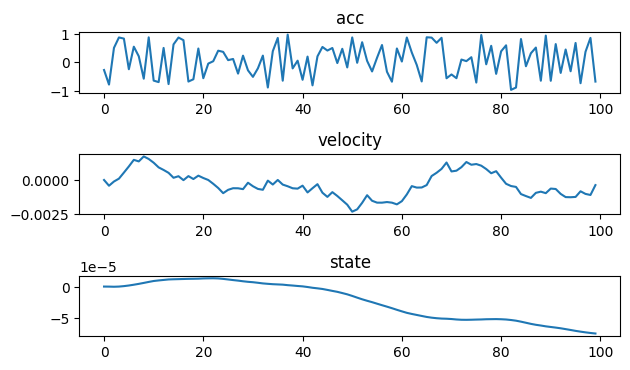

In [12]:
i = 100
t = range(len(data[:i]))
plt.figure()
# plt.subplot(4, 1, 1)
# plt.title('force')
# plt.plot(t, data['Fx'][:i])
plt.subplot(4, 1, 2)
plt.plot(t, data['dvx'][:i])
plt.title('acc')
plt.subplot(4, 1, 3)
plt.title('velocity')
plt.plot(t, data['vx'][:i])
plt.subplot(4, 1, 4)
plt.title('state')
plt.plot(t, data['rx'][:i])
plt.tight_layout()

## data loader

In [15]:
from torch.utils.data import Dataset


class FDataset(Dataset):
    def __init__(self, total_data: pd.DataFrame, input_dim: int, data_type: str, predict_column: str):
        self.data_input_sequence_length = input_dim
        self.total_data_num = len(total_data) - input_dim
        self.data_type = data_type
        self.output_col = predict_column
        # train_last, valid_last : last index number for train, valid (abs value)
        train_data_num = self.total_data_num*8//10
        valid_data_num = self.total_data_num*9//10
        if self.data_type == 'train':
            data = total_data[:train_data_num + input_dim]
        elif self.data_type == 'valid':
            data = total_data[train_data_num: valid_data_num + input_dim]
        elif self.data_type == 'test':
            data = total_data[valid_data_num:]
        self.data = data

    def __len__(self):
        # return len(self.data)
        return len(self.data) - self.data_input_sequence_length - 1

    def __getitem__(self, idx):
        if self.output_col == 'acc':
            input_col = ['rx','ry','rz','vx','vy','vz']
            output_col = ['dvx', 'dvy', 'dvz']
        elif self.output_col == 'vel':
            input_col = ['rx','ry','rz','dvx','dvy','dvz']
            output_col = ['vx', 'vy', 'vz']
        elif self.output_col == 'state':
            input_col = ['vx', 'vy', 'vz','dvx','dvy','dvz']
            output_col = ['rx', 'ry', 'rz']
        elif self.output_col == 'vel2':
            input_col = ['vx', 'vy', 'vz','dvx','dvy','dvz']
            output_col = ['vx', 'vy', 'vz']
        elif self.output_col == 'vel3':
            input_col = ['rx','ry','rz','vx', 'vy', 'vz','dvx','dvy','dvz']
            output_col = ['vx', 'vy', 'vz']
        x = np.array(self.data[input_col])[idx: idx+self.data_input_sequence_length]
        y = np.array(self.data[output_col])[idx+self.data_input_sequence_length]
        t = np.array(list(range(idx, idx+self.data_input_sequence_length)))
        return t, x, y

In [16]:
train_dataset = FDataset(total_data=data, data_type="train", predict_column='acc', input_dim=20)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=5)

In [18]:
for i, (t, x, y) in enumerate(train_loader):
    try:
        a = x
    except:
        print(i)

In [19]:
print(t, x, y)

tensor([[7980, 7981, 7982, 7983, 7984, 7985, 7986, 7987, 7988, 7989, 7990, 7991,
         7992, 7993, 7994, 7995, 7996, 7997, 7998, 7999],
        [7981, 7982, 7983, 7984, 7985, 7986, 7987, 7988, 7989, 7990, 7991, 7992,
         7993, 7994, 7995, 7996, 7997, 7998, 7999, 8000],
        [7982, 7983, 7984, 7985, 7986, 7987, 7988, 7989, 7990, 7991, 7992, 7993,
         7994, 7995, 7996, 7997, 7998, 7999, 8000, 8001]]) tensor([[[-0.0484, -0.1145,  0.0686, -0.0316, -0.0097,  0.0012],
         [-0.0485, -0.1145,  0.0686, -0.0315, -0.0098,  0.0011],
         [-0.0485, -0.1145,  0.0686, -0.0314, -0.0100,  0.0015],
         [-0.0485, -0.1145,  0.0686, -0.0310, -0.0101,  0.0016],
         [-0.0485, -0.1145,  0.0686, -0.0313, -0.0103,  0.0022],
         [-0.0486, -0.1145,  0.0687, -0.0308, -0.0103,  0.0024],
         [-0.0486, -0.1146,  0.0687, -0.0312, -0.0102,  0.0022],
         [-0.0486, -0.1146,  0.0687, -0.0310, -0.0098,  0.0025],
         [-0.0486, -0.1146,  0.0687, -0.0304, -0.0099,  0.0022

# Modeling

In [20]:
class FLSTM(nn.Module):
    def __init__(
        self,
        input_dim=6,
        lstm_hidden_dim=128,
        output_dim=3,
        num_layers=1,
        bidirectional=False,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=lstm_hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
        )

        self.hidden_dim = lstm_hidden_dim * num_layers

        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()

        self.bn0 = nn.BatchNorm1d(self.hidden_dim // 2)

        self.fc0 = nn.Linear(self.hidden_dim, self.hidden_dim // 2)
        self.fc1 = nn.Linear(self.hidden_dim // 2, output_dim)

    def forward(self, seq_x):
        _, (h_t, c_t) = self.lstm(
            seq_x.float()
        )  # h_t dim = [num_layers, batch_size, LSTM_output_dim]
        output = h_t.permute(
            1, 0, 2
        )  # output dim = [batch_size, num_layers, LSTM_output_dim]
        output = self.flatten(
            output
        )  # output dim = [batch_size, num_layers*LSTM_output_dim]
        output = self.relu(
            self.bn0(self.fc0(output))
        )  # output = [batch_size, fc0_output_dim]
        output = self.fc1(output)  # output = [batch_size, fc1_output_dim]

        return output


In [21]:
model = FLSTM()

In [22]:
y_test = model(x)

In [23]:
y_test

tensor([[0.0171, 0.0800, 0.0096],
        [0.0167, 0.0801, 0.0094],
        [0.0174, 0.0796, 0.0106]], grad_fn=<AddmmBackward0>)

In [24]:
model

FLSTM(
  (lstm): LSTM(6, 128, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (bn0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=128, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=3, bias=True)
)

In [25]:
layer_sizes = [50, 50, 50]

class LSTMModel(nn.Module):
    def __init__(self, layer_sizes, n_features, n_target):
        super(LSTMModel, self).__init__()
        self.layer_sizes = layer_sizes
        self.n_layers = len(layer_sizes)
        self.n_features = n_features
        self.n_target = n_target
        
        self.lstm = nn.LSTM(
            input_size=n_features, 
            hidden_size=layer_sizes[0], 
            num_layers=self.n_layers, 
            batch_first=True
        )
        self.fc_layers = nn.ModuleList(
            [nn.Linear(layer_sizes[i], layer_sizes[i+1]) for i in range(self.n_layers-1)]
        )
        self.output_layer = nn.Linear(layer_sizes[-1], n_target)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x.float())
        out = lstm_out[:, -1, :]
        for i, layer in enumerate(self.fc_layers):
            out = layer(out)
            out = nn.ReLU()(out)
        out = self.output_layer(out)
        return out


# Train

## general functions

In [29]:
class Args:
    def __init__(
        self,
        model_name='F_uniform_LSTM',
        data_dir='data.csv',
        device=torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu'),
        input_dim=20,
        hidden_dim1=100,
        loss='L2',
        batch_size=16,
        num_layers=1,
        weight_decay=1e-6,
        learning_rate=1e-3,
        n_epochs=500,
        logging_level='info',
        predict_col='state'
    ):
        self.model_name=model_name
        self.data_dir=data_dir
        self.device=device
        self.input_dim=input_dim
        self.hidden_dim1=hidden_dim1
        self.loss=loss
        self.batch_size=batch_size
        self.num_layers=num_layers
        self.weight_decay=weight_decay
        self.learning_rate=learning_rate
        self.n_epochs=n_epochs
        self.logging_level=logging_level
        self.predict_column=predict_col

args = Args()
args.n_epochs

500

In [ ]:
# # initial setting
# predict_col = 'acc'
# save_name = "acc&vel_to_state"

# # data
# train_dataset = FDataset(total_data=data, data_type="train", predict_column=predict_col, input_dim=args.input_sequence_length)
# train_loader = DataLoader(train_dataset, batch_size=5)

# # model
# model = FLSTM()

# # train
# logger.setLevel(logging_dict[args.logging_level])
# save_dir = f"{parent_dir}/models/{args.model_name}/{save_name}"
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# device = args.device if torch.cuda.is_available() else "cpu"

# train_dataset = FDataset(total_data=data, data_type="train", predict_column=args.predict_column, input_dim=args.input_dim)
# valid_dataset = FDataset(total_data=data, data_type="valid", predict_column=args.predict_column, input_dim=args.input_dim)
# test_dataset = FDataset(total_data=data, data_type="test", predict_column=args.predict_column, input_dim=args.input_dim)

# train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True)
# valid_loader = DataLoader(dataset=valid_dataset, batch_size=args.batch_size)
# test_loader = DataLoader(dataset=test_dataset, batch_size=args.batch_size)

# pytorch_total_params = sum(p.numel() for p in model.parameters())
# pytorch_total_params

# md_file_name = os.path.join(save_dir, f"{save_name}.md")
# with open(md_file_name, "w") as f:
#     f.write("### Argument Values\n")
#     for k, v in args.__dict__.items():
#         f.write(f"- {k}={v}\n")
#     f.write("\n### Model Architecture\n")
#     f.write(f"```\n{model}\n```\n")
#     f.write("\n### Parameter Number\n")
#     f.write(f"- {pytorch_total_params}")
    
# lstm_input_dim = len(train_dataset[0][1][-1])
# model = FLSTM(
#     input_dim = lstm_input_dim,
#     lstm_hidden_dim=args.hidden_dim1,
#     output_dim=3,
#     num_layers=args.num_layers,
#     bidirectional=False
# )
# logging.info(model)

# criterion = loss_funcs[args.loss]

# lr = args.learning_rate
# optimizer = torch.optim.Adam(
#     model.parameters(), lr=lr, weight_decay=args.weight_decay
# )

# save_name = os.path.join(save_dir, f"{save_name}.pth")
# logging.info(save_name)

# logging.info("*--------Start Training--------*")

# train_valid_evaluate = TrainValidEvaluate(
#     model=model,
#     train_loader=train_loader,
#     valid_loader=valid_loader,
#     test_loader=test_loader,
#     n_epochs=args.n_epochs,
#     optimizer=optimizer,
#     criterion=criterion,
#     device=device,
#     path=save_name,
#     logging=logging,
#     train_stop_iter = 1000
#     # writer=writer
# )
# train_valid_evaluate.sin_train()
# train_valid_evaluate.sin_test()
# # writer.flush()

# logging.info(
#     f"TEST SCORE :: \n \ttest MAPE={train_valid_evaluate.avg_test_mape:.4f} \n\ttest loss={train_valid_evaluate.avg_test_loss:.4f}"
# )

# pre_ = train_valid_evaluate.test_prediction_result
# true_ = train_valid_evaluate.test_target_result


# # i = 200
# i = len(true_)

# for j, sym in enumerate(['x','y','z']):
#     plt.figure()
#     true_values = [x[-1][j] for x in true_[:i]]
#     pre_values = [x[-1][j] for x in pre_[:i]]
#     min_, max_ = min(min(true_values), min(pre_values)), max(max(true_values), max(pre_values))
#     gap = (max_-min_)/10
#     min_, max_ = min_-gap, max_+gap
#     plt.subplot(2, 1, 1)
#     plt.title('true')
#     plt.plot(range(i), true_values, label=f'{predict_col}_{sym}')
#     plt.legend()
#     plt.ylim([min_, max_])
#     plt.subplot(2, 1, 2)
#     plt.title('predict')
#     plt.plot(range(i), pre_values, label=f'{predict_col}_{sym}')
#     plt.legend()
#     plt.ylim([min_, max_])
#     plt.tight_layout()

## input: [0, t] 구간의 acc, vel → output: [t+1] 시점의 state

In [27]:
class Args:
    def __init__(
        self,
        model_name='F_uniform_LSTM',
        data_dir='data.csv',
        device=torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu'),
        input_dim=20,
        hidden_dim1=100,
        loss='L2',
        batch_size=16,
        num_layers=1,
        weight_decay=1e-6,
        learning_rate=1e-3,
        n_epochs=500,
        logging_level='info',
        predict_col='state'
    ):
        self.model_name=model_name
        self.data_dir=data_dir
        self.device=device
        self.input_dim=input_dim
        self.hidden_dim1=hidden_dim1
        self.loss=loss
        self.batch_size=batch_size
        self.num_layers=num_layers
        self.weight_decay=weight_decay
        self.learning_rate=learning_rate
        self.n_epochs=n_epochs
        self.logging_level=logging_level
        self.predict_column=predict_col

args = Args()
args.n_epochs

500

In [ ]:
# from torch.utils.tensorboard import SummaryWriter


np.random.seed(42)

logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)


logging_dict = {
    "debug": logging.DEBUG,
    "info": logging.INFO,
    "warning": logging.WARNING,
    "error": logging.ERROR,
    "critical": logging.CRITICAL,
}
logger.setLevel(logging_dict[args.logging_level])
save_name = f"acc&vel_to_state"
save_dir = f"{parent_dir}/models/{args.model_name}/{save_name}"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

device = args.device if torch.cuda.is_available() else "cpu"

train_dataset = FDataset(total_data=data, data_type="train", predict_column=args.predict_column, input_dim=args.input_dim)
valid_dataset = FDataset(total_data=data, data_type="valid", predict_column=args.predict_column, input_dim=args.input_dim)
test_dataset = FDataset(total_data=data, data_type="test", predict_column=args.predict_column, input_dim=args.input_dim)

train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=args.batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=args.batch_size)

In [ ]:
md_file_name = os.path.join(save_dir, f"{save_name}.md")
with open(md_file_name, "w") as f:
    f.write("### Argument Values\n")
    for k, v in args.__dict__.items():
        f.write(f"- {k}={v}\n")

In [ ]:
lstm_input_dim = len(train_dataset[0][1][-1])
model = FLSTM(
    input_dim = lstm_input_dim,
    lstm_hidden_dim=args.hidden_dim1,
    output_dim=3,
    num_layers=args.num_layers,
    bidirectional=False
)
print(model)

# hyper-params
loss_funcs = {"L2": nn.MSELoss()}
criterion = loss_funcs[args.loss]

lr = args.learning_rate
optimizer = torch.optim.Adam(
    model.parameters(), lr=lr, weight_decay=args.weight_decay
)

save_name = os.path.join(save_dir, f"{save_name}.pth")
logging.info(save_name)

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

In [ ]:
logging.info("*--------Start Training--------*")

train_valid_evaluate = TrainValidEvaluate(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    n_epochs=args.n_epochs,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    path=save_name,
    logging=logging,
    train_stop_iter = 1000
    # writer=writer
)
train_valid_evaluate.sin_train()
train_valid_evaluate.sin_test()
# writer.flush()

logging.info(
    f"TEST SCORE :: \n \ttest MAPE={train_valid_evaluate.avg_test_mape:.4f} \n\ttest loss={train_valid_evaluate.avg_test_loss:.4f}"
)

In [ ]:
pre_ = train_valid_evaluate.test_prediction_result
true_ = train_valid_evaluate.test_target_result

In [ ]:
# i = 200
i = len(true_)

nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))

for j, sym in enumerate(['x','y','z']):
    true_values = [x[-1][j] for x in true_[:i]]
    pre_values = [x[-1][j] for x in pre_[:i]]
    min_, max_ = min(min(true_values), min(pre_values)), max(max(true_values), max(pre_values))
    gap = (max_-min_)/10
    min_, max_ = min_-gap, max_+gap
    
    ax = axes[j][0]
    ax.set_title('true')
    ax.plot(range(i), true_values, label=f'r_{sym}')
    ax.legend()
    ax.set_ylim([min_, max_])

    ax = axes[j][1]
    ax.set_title('predict')
    ax.plot(range(i), pre_values, label=f'r_{sym}')
    ax.legend()
    ax.set_ylim([min_, max_])
plt.tight_layout()
    

## input: [0, t] 구간의 state, vel → output: [t+1] 시점의 acc

In [ ]:
# initial setting
predict_col = 'acc'
save_name = "state&vel_to_acc"


# train
logger.setLevel(logging_dict[args.logging_level])
save_dir = f"{parent_dir}/models/{args.model_name}/{save_name}"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

device = args.device if torch.cuda.is_available() else "cpu"

train_dataset = FDataset(total_data=data, data_type="train", predict_column=args.predict_column, input_dim=args.input_sequence_length)
valid_dataset = FDataset(total_data=data, data_type="valid", predict_column=args.predict_column, input_dim=args.input_sequence_length)
test_dataset = FDataset(total_data=data, data_type="test", predict_column=args.predict_column, input_dim=args.input_sequence_length)

train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=args.batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=args.batch_size)

pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

md_file_name = os.path.join(save_dir, f"{save_name}.md")
with open(md_file_name, "w") as f:
    f.write("### Argument Values\n")
    for k, v in args.__dict__.items():
        f.write(f"- {k}={v}\n")
    f.write("\n### Model Architecture\n")
    f.write(f"```{model}```\n")
    f.write("\n### Parameter Number\n")
    f.write(f"- {pytorch_total_params}")
    
lstm_input_dim = len(train_dataset[0][1][-1])
model = FLSTM(
    input_dim = lstm_input_dim,
    lstm_hidden_dim=args.hidden_dim1,
    output_dim=3,
    num_layers=args.num_layers,
    bidirectional=False
)
logging.info(model)

criterion = loss_funcs[args.loss]

lr = args.learning_rate
optimizer = torch.optim.Adam(
    model.parameters(), lr=lr, weight_decay=args.weight_decay
)

save_name = os.path.join(save_dir, f"{save_name}.pth")
logging.info(save_name)

logging.info("*--------Start Training--------*")

train_valid_evaluate = TrainValidEvaluate(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    n_epochs=args.n_epochs,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    path=save_name,
    logging=logging,
    train_stop_iter = 1000
    # writer=writer
)
train_valid_evaluate.sin_train()
train_valid_evaluate.sin_test()
# writer.flush()

logging.info(
    f"TEST SCORE :: \n \ttest MAPE={train_valid_evaluate.avg_test_mape:.4f} \n\ttest loss={train_valid_evaluate.avg_test_loss:.4f}"
)

pre_ = train_valid_evaluate.test_prediction_result
true_ = train_valid_evaluate.test_target_result


# i = 200
i = len(true_)

nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))

for j, sym in enumerate(['x','y','z']):
    true_values = [x[-1][j] for x in true_[:i]]
    pre_values = [x[-1][j] for x in pre_[:i]]
    min_, max_ = min(min(true_values), min(pre_values)), max(max(true_values), max(pre_values))
    gap = (max_-min_)/10
    min_, max_ = min_-gap, max_+gap
    
    ax = axes[j][0]
    ax.set_title('true')
    ax.plot(range(i), true_values, label=f'{predict_col}_{sym}')
    ax.legend()
    ax.set_ylim([min_, max_])

    ax = axes[j][1]
    ax.set_title('predict')
    ax.plot(range(i), pre_values, label=f'{predict_col}_{sym}')
    ax.legend()
    ax.set_ylim([min_, max_])
plt.tight_layout()
    

## input: [0, t] 구간의 acc, vel → output: [t+1] 시점의 vel

In [27]:
# initial setting
predict_col = 'vel2'
save_name = "vel&acc_to_vel"
args.num_layers = 5

# train
logger.setLevel(logging_dict[args.logging_level])
save_dir = f"{parent_dir}/models/{args.model_name}/{save_name}"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

device = args.device if torch.cuda.is_available() else "cpu"

train_dataset = FDataset(total_data=data, data_type="train", predict_column=args.predict_column, input_dim=args.input_sequence_length)
valid_dataset = FDataset(total_data=data, data_type="valid", predict_column=args.predict_column, input_dim=args.input_sequence_length)
test_dataset = FDataset(total_data=data, data_type="test", predict_column=args.predict_column, input_dim=args.input_sequence_length)

train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=args.batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=args.batch_size)

pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

md_file_name = os.path.join(save_dir, f"{save_name}.md")
with open(md_file_name, "w") as f:
    f.write("### Argument Values\n")
    for k, v in args.__dict__.items():
        f.write(f"- {k}={v}\n")
    f.write("\n### Model Architecture\n")
    f.write(f"```{model}```\n")
    f.write("\n### Parameter Number\n")
    f.write(f"- {pytorch_total_params}")
    
lstm_input_dim = len(train_dataset[0][1][-1])
model = FLSTM(
    input_dim = lstm_input_dim,
    lstm_hidden_dim=args.hidden_dim1,
    output_dim=3,
    num_layers=args.num_layers,
    bidirectional=False
)
logging.info(model)

criterion = loss_funcs[args.loss]

lr = args.learning_rate
optimizer = torch.optim.Adam(
    model.parameters(), lr=lr, weight_decay=args.weight_decay
)

save_name = os.path.join(save_dir, f"{save_name}.pth")
logging.info(save_name)

logging.info("*--------Start Training--------*")

train_valid_evaluate = TrainValidEvaluate(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    n_epochs=args.n_epochs,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    path=save_name,
    logging=logging,
    train_stop_iter = 1000
    # writer=writer
)
train_valid_evaluate.sin_train()
train_valid_evaluate.sin_test()
# writer.flush()

logging.info(
    f"TEST SCORE :: \n \ttest MAPE={train_valid_evaluate.avg_test_mape:.4f} \n\ttest loss={train_valid_evaluate.avg_test_loss:.4f}"
)

pre_ = train_valid_evaluate.test_prediction_result
true_ = train_valid_evaluate.test_target_result

2023-02-17 14:56:10,664 - INFO - FLSTM(
  (lstm): LSTM(6, 100, num_layers=5, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (bn0): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=500, out_features=250, bias=True)
  (fc1): Linear(in_features=250, out_features=3, bias=True)
)
2023-02-17 14:56:10,667 - INFO - /Users/a10961/Documents/42dot/accidentdetection_lv2/models/F_uniform_LSTM/vel&acc_to_vel/vel&acc_to_vel.pth
2023-02-17 14:56:10,668 - INFO - *--------Start Training--------*
249it [00:36,  6.75it/s]
2023-02-17 14:56:49,464 - INFO - train_loss: 0.0433 train_mape: 202.1518 || valid_loss: 0.0559 valid_mape: 0.6190
249it [00:38,  6.51it/s]
2023-02-17 14:57:29,656 - INFO - train_loss: 0.0255 train_mape: 586.5761 || valid_loss: 0.0529 valid_mape: 0.6110
249it [00:41,  5.94it/s]
2023-02-17 14:58:13,941 - INFO - train_loss: 0.0242 train_mape: 936.9076 || valid_loss: 0.0717 valid_mape: 0.8442
249i

249it [01:19,  3.12it/s]
2023-02-17 15:58:09,208 - INFO - train_loss: 0.0064 train_mape: 217.1365 || valid_loss: 0.0319 valid_mape: 0.3571
249it [01:14,  3.35it/s]
2023-02-17 15:59:27,036 - INFO - train_loss: 0.0064 train_mape: 188.0491 || valid_loss: 0.0201 valid_mape: 0.2172
249it [01:07,  3.71it/s]
2023-02-17 16:00:37,732 - INFO - train_loss: 0.0064 train_mape: 249.0431 || valid_loss: 0.0594 valid_mape: 0.6764
249it [01:05,  3.80it/s]
2023-02-17 16:01:46,863 - INFO - train_loss: 0.0063 train_mape: 378.4190 || valid_loss: 0.0111 valid_mape: 0.1160
2023-02-17 16:01:46,869 - INFO - Saving best performance model
249it [01:06,  3.76it/s]
2023-02-17 16:02:56,532 - INFO - train_loss: 0.0064 train_mape: 259.9374 || valid_loss: 0.0260 valid_mape: 0.2668
249it [01:01,  4.08it/s]
2023-02-17 16:04:00,835 - INFO - train_loss: 0.0062 train_mape: 5.1774 || valid_loss: 0.0314 valid_mape: 0.3516
249it [00:56,  4.43it/s]
2023-02-17 16:05:00,083 - INFO - train_loss: 0.0063 train_mape: 84.8869 || valid

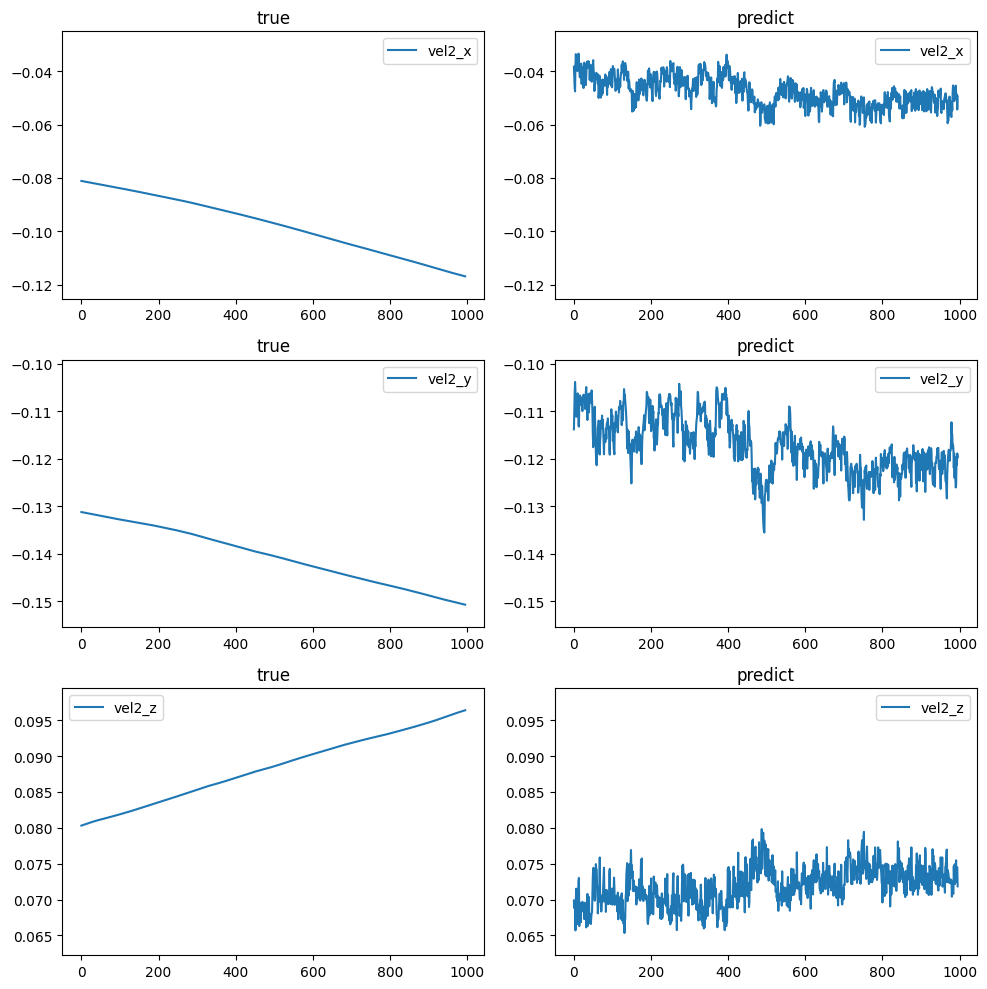

In [25]:

# i = 200
i = len(true_)

nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))

for j, sym in enumerate(['x','y','z']):
    true_values = [x[-1][j] for x in true_[:i]]
    pre_values = [x[-1][j] for x in pre_[:i]]
    min_, max_ = min(min(true_values), min(pre_values)), max(max(true_values), max(pre_values))
    gap = (max_-min_)/10
    min_, max_ = min_-gap, max_+gap
    
    ax = axes[j][0]
    ax.set_title('true')
    ax.plot(range(i), true_values, label=f'{predict_col}_{sym}')
    ax.legend()
    ax.set_ylim([min_, max_])

    ax = axes[j][1]
    ax.set_title('predict')
    ax.plot(range(i), pre_values, label=f'{predict_col}_{sym}')
    ax.legend()
    ax.set_ylim([min_, max_])
plt.tight_layout()
    

## input: [0, t] 구간의 state, acc, vel → output: [t+1] 시점의 vel (승은님 모델 적용)

In [30]:
# 승은님 모델을 그대로 따와서 학습해보면

# initial setting
args.predict_column = 'vel3'
save_name = "vel&acc&state_to_vel_v2"
args.num_layers = 5
args.epoch = 3000
layer_sizes = [50, 50, 50]
args.input_sequence_length = 1

# train
logger.setLevel(logging_dict[args.logging_level])
save_dir = f"{parent_dir}/models/{args.model_name}/{save_name}"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

device = args.device if torch.cuda.is_available() else "cpu"

train_dataset = FDataset(
    total_data=data, 
    data_type="train", 
    predict_column=args.predict_column, 
    input_dim=args.input_sequence_length
)
valid_dataset = FDataset(
    total_data=data, 
    data_type="valid", 
    predict_column=args.predict_column, 
    input_dim=args.input_sequence_length
)
test_dataset = FDataset(
    total_data=data, 
    data_type="test", 
    predict_column=args.predict_column, 
    input_dim=args.input_sequence_length
)

train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=args.batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=args.batch_size)

pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

md_file_name = os.path.join(save_dir, f"{save_name}.md")
with open(md_file_name, "w") as f:
    f.write("### Argument Values\n")
    for k, v in args.__dict__.items():
        f.write(f"- {k}={v}\n")
    f.write("\n### Model Architecture\n")
    f.write(f"```{model}```\n")
    f.write("\n### Parameter Number\n")
    f.write(f"- {pytorch_total_params}")
    
lstm_input_dim = len(train_dataset[0][1][-1])
model = LSTMModel(
    layer_sizes = layer_sizes, 
    n_features = lstm_input_dim,
    n_target = 3
)

# model = FLSTM(
#     input_dim = lstm_input_dim,
#     lstm_hidden_dim=args.hidden_dim1,
#     output_dim=3,
#     num_layers=args.num_layers,
#     bidirectional=False
# )
logging.info(model)

criterion = nn.MSELoss()

lr = args.learning_rate
optimizer = torch.optim.Adam(
    model.parameters(), lr=lr, weight_decay=args.weight_decay
)

save_name = os.path.join(save_dir, f"{save_name}.pth")
logging.info(save_name)

logging.info("*--------Start Training--------*")

train_valid_evaluate = TrainValidEvaluate(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    n_epochs=args.n_epochs,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    path=save_name,
    logging=logging,
    train_stop_iter = 3000
    # writer=writer
)
train_valid_evaluate.sin_train()
train_valid_evaluate.sin_test()
# writer.flush()

logging.info(
    f"TEST SCORE :: \n \ttest MAPE={train_valid_evaluate.avg_test_mape:.4f} \n\ttest loss={train_valid_evaluate.avg_test_loss:.4f}"
)

pre_ = train_valid_evaluate.test_prediction_result
true_ = train_valid_evaluate.test_target_result



2023-02-21 11:01:36,493 - INFO - LSTMModel(
  (lstm): LSTM(9, 50, num_layers=3, batch_first=True)
  (fc_layers): ModuleList(
    (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (output_layer): Linear(in_features=50, out_features=3, bias=True)
)
2023-02-21 11:01:36,494 - INFO - /Users/a11910/Documents/42dot/accidentdetection_lv2/models/F_uniform_LSTM/vel&acc&state_to_vel_v2/vel&acc&state_to_vel_v2.pth
2023-02-21 11:01:36,494 - INFO - *--------Start Training--------*
500it [00:03, 145.36it/s]
2023-02-21 11:01:40,232 - INFO - train_loss: 0.0116 train_mape: 35.3153 || valid_loss: 0.0156 valid_mape: 4.5870
500it [00:03, 146.34it/s]
2023-02-21 11:01:43,935 - INFO - train_loss: 0.0091 train_mape: 7.1337 || valid_loss: 0.0150 valid_mape: 4.6717
500it [00:03, 147.83it/s]
2023-02-21 11:01:47,601 - INFO - train_loss: 0.0092 train_mape: 7.9571 || valid_loss: 0.0139 valid_mape: 4.2802
500it [00:03, 147.21it/s]
2023-02-21 11:01:51,283 - INFO - train_loss: 0.0092 train_mape: 7.299

500it [00:03, 147.52it/s]
2023-02-21 11:05:00,366 - INFO - train_loss: 0.0091 train_mape: 8.0990 || valid_loss: 0.0143 valid_mape: 4.9197
500it [00:03, 147.11it/s]
2023-02-21 11:05:04,048 - INFO - train_loss: 0.0091 train_mape: 9.2066 || valid_loss: 0.0148 valid_mape: 3.8319
500it [00:03, 142.12it/s]
2023-02-21 11:05:07,990 - INFO - train_loss: 0.0091 train_mape: 8.4332 || valid_loss: 0.0164 valid_mape: 5.3625
500it [00:03, 140.61it/s]
2023-02-21 11:05:11,845 - INFO - train_loss: 0.0091 train_mape: 8.1974 || valid_loss: 0.0139 valid_mape: 4.2039
500it [00:03, 144.82it/s]
2023-02-21 11:05:15,580 - INFO - train_loss: 0.0091 train_mape: 8.6734 || valid_loss: 0.0158 valid_mape: 4.1085
500it [00:03, 138.64it/s]
2023-02-21 11:05:19,481 - INFO - train_loss: 0.0091 train_mape: 8.5860 || valid_loss: 0.0150 valid_mape: 4.2254
500it [00:03, 132.11it/s]
2023-02-21 11:05:23,561 - INFO - train_loss: 0.0091 train_mape: 8.5142 || valid_loss: 0.0163 valid_mape: 5.1866
500it [00:03, 133.01it/s]
2023-02-

500it [00:03, 134.77it/s]
2023-02-21 11:08:42,187 - INFO - train_loss: 0.0091 train_mape: 9.1297 || valid_loss: 0.0160 valid_mape: 4.0489
500it [00:03, 146.43it/s]
2023-02-21 11:08:45,895 - INFO - train_loss: 0.0091 train_mape: 8.6309 || valid_loss: 0.0159 valid_mape: 4.4359
500it [00:03, 145.71it/s]
2023-02-21 11:08:49,617 - INFO - train_loss: 0.0091 train_mape: 8.2825 || valid_loss: 0.0143 valid_mape: 4.4662
500it [00:03, 146.84it/s]
2023-02-21 11:08:53,306 - INFO - train_loss: 0.0091 train_mape: 7.7795 || valid_loss: 0.0154 valid_mape: 4.2014
500it [00:03, 148.93it/s]
2023-02-21 11:08:56,947 - INFO - train_loss: 0.0091 train_mape: 8.5803 || valid_loss: 0.0165 valid_mape: 4.1942
500it [00:03, 149.13it/s]
2023-02-21 11:09:00,593 - INFO - train_loss: 0.0091 train_mape: 8.4813 || valid_loss: 0.0151 valid_mape: 4.0291
500it [00:03, 144.18it/s]
2023-02-21 11:09:04,345 - INFO - train_loss: 0.0090 train_mape: 8.5268 || valid_loss: 0.0155 valid_mape: 5.0094
500it [00:03, 143.15it/s]
2023-02-

500it [00:03, 145.96it/s]
2023-02-21 11:12:27,547 - INFO - train_loss: 0.0091 train_mape: 8.7053 || valid_loss: 0.0158 valid_mape: 4.9714
500it [00:03, 145.08it/s]
2023-02-21 11:12:31,279 - INFO - train_loss: 0.0091 train_mape: 8.2125 || valid_loss: 0.0160 valid_mape: 4.8726
500it [00:03, 144.38it/s]
2023-02-21 11:12:35,030 - INFO - train_loss: 0.0091 train_mape: 8.6470 || valid_loss: 0.0151 valid_mape: 4.5930
500it [00:03, 144.75it/s]
2023-02-21 11:12:38,772 - INFO - train_loss: 0.0091 train_mape: 8.2925 || valid_loss: 0.0166 valid_mape: 4.7904
500it [00:03, 146.23it/s]
2023-02-21 11:12:42,478 - INFO - train_loss: 0.0091 train_mape: 8.4614 || valid_loss: 0.0137 valid_mape: 3.8856
500it [00:03, 148.07it/s]
2023-02-21 11:12:46,146 - INFO - train_loss: 0.0091 train_mape: 8.5697 || valid_loss: 0.0152 valid_mape: 4.2673
500it [00:03, 147.11it/s]
2023-02-21 11:12:49,834 - INFO - train_loss: 0.0091 train_mape: 8.4508 || valid_loss: 0.0146 valid_mape: 3.9840
500it [00:03, 147.26it/s]
2023-02-

500it [00:03, 148.99it/s]
2023-02-21 11:16:14,623 - INFO - train_loss: 0.0091 train_mape: 8.3086 || valid_loss: 0.0151 valid_mape: 4.8127
500it [00:03, 149.01it/s]
2023-02-21 11:16:18,264 - INFO - train_loss: 0.0091 train_mape: 8.1150 || valid_loss: 0.0156 valid_mape: 4.0088
500it [00:03, 148.24it/s]
2023-02-21 11:16:21,927 - INFO - train_loss: 0.0091 train_mape: 8.2622 || valid_loss: 0.0156 valid_mape: 4.9986
500it [00:03, 148.75it/s]
2023-02-21 11:16:25,575 - INFO - train_loss: 0.0091 train_mape: 8.3644 || valid_loss: 0.0145 valid_mape: 5.1615
500it [00:03, 149.49it/s]
2023-02-21 11:16:29,206 - INFO - train_loss: 0.0091 train_mape: 7.9428 || valid_loss: 0.0162 valid_mape: 4.5155
500it [00:03, 147.90it/s]
2023-02-21 11:16:32,875 - INFO - train_loss: 0.0091 train_mape: 9.0001 || valid_loss: 0.0155 valid_mape: 3.8147
500it [00:03, 149.82it/s]
2023-02-21 11:16:36,499 - INFO - train_loss: 0.0091 train_mape: 8.4864 || valid_loss: 0.0167 valid_mape: 5.2154
500it [00:03, 149.05it/s]
2023-02-

500it [00:03, 143.79it/s]
2023-02-21 11:19:56,217 - INFO - train_loss: 0.0091 train_mape: 8.2233 || valid_loss: 0.0147 valid_mape: 4.0600
500it [00:03, 140.09it/s]
2023-02-21 11:20:00,075 - INFO - train_loss: 0.0091 train_mape: 8.3213 || valid_loss: 0.0162 valid_mape: 4.1812
500it [00:03, 140.65it/s]
2023-02-21 11:20:03,922 - INFO - train_loss: 0.0091 train_mape: 7.7393 || valid_loss: 0.0150 valid_mape: 4.4040
500it [00:03, 138.85it/s]
2023-02-21 11:20:07,812 - INFO - train_loss: 0.0091 train_mape: 8.7152 || valid_loss: 0.0152 valid_mape: 4.4854
500it [00:03, 136.06it/s]
2023-02-21 11:20:11,792 - INFO - train_loss: 0.0090 train_mape: 8.5084 || valid_loss: 0.0148 valid_mape: 4.3227
500it [00:03, 144.86it/s]
2023-02-21 11:20:15,530 - INFO - train_loss: 0.0091 train_mape: 8.5334 || valid_loss: 0.0162 valid_mape: 5.1480
500it [00:03, 147.12it/s]
2023-02-21 11:20:19,217 - INFO - train_loss: 0.0091 train_mape: 8.7498 || valid_loss: 0.0159 valid_mape: 4.6601
500it [00:03, 140.53it/s]
2023-02-

500it [00:03, 152.05it/s]
2023-02-21 11:23:37,061 - INFO - train_loss: 0.0091 train_mape: 8.5948 || valid_loss: 0.0152 valid_mape: 3.7834
500it [00:03, 149.60it/s]
2023-02-21 11:23:40,695 - INFO - train_loss: 0.0091 train_mape: 8.6671 || valid_loss: 0.0148 valid_mape: 4.1614
500it [00:03, 150.87it/s]
2023-02-21 11:23:44,294 - INFO - train_loss: 0.0091 train_mape: 8.0095 || valid_loss: 0.0155 valid_mape: 4.7306
500it [00:03, 152.20it/s]
2023-02-21 11:23:47,862 - INFO - train_loss: 0.0090 train_mape: 8.7065 || valid_loss: 0.0154 valid_mape: 4.3866
500it [00:03, 151.75it/s]
2023-02-21 11:23:51,438 - INFO - train_loss: 0.0091 train_mape: 8.4886 || valid_loss: 0.0152 valid_mape: 4.7322
500it [00:03, 151.52it/s]
2023-02-21 11:23:55,023 - INFO - train_loss: 0.0091 train_mape: 8.6254 || valid_loss: 0.0144 valid_mape: 3.9976
500it [00:03, 152.96it/s]
2023-02-21 11:23:58,573 - INFO - train_loss: 0.0090 train_mape: 8.7933 || valid_loss: 0.0157 valid_mape: 4.0759
500it [00:03, 150.66it/s]
2023-02-

500it [00:03, 148.62it/s]
2023-02-21 11:27:13,681 - INFO - train_loss: 0.0091 train_mape: 8.8698 || valid_loss: 0.0165 valid_mape: 5.0481
500it [00:03, 149.71it/s]
2023-02-21 11:27:17,302 - INFO - train_loss: 0.0090 train_mape: 8.0162 || valid_loss: 0.0163 valid_mape: 4.4223
500it [00:03, 149.16it/s]
2023-02-21 11:27:20,936 - INFO - train_loss: 0.0091 train_mape: 8.5476 || valid_loss: 0.0158 valid_mape: 4.4094
500it [00:03, 149.67it/s]
2023-02-21 11:27:24,561 - INFO - train_loss: 0.0091 train_mape: 8.5378 || valid_loss: 0.0153 valid_mape: 4.5904
500it [00:03, 150.03it/s]
2023-02-21 11:27:28,175 - INFO - train_loss: 0.0091 train_mape: 8.1703 || valid_loss: 0.0148 valid_mape: 4.1304
500it [00:03, 150.46it/s]
2023-02-21 11:27:31,781 - INFO - train_loss: 0.0090 train_mape: 8.3407 || valid_loss: 0.0166 valid_mape: 4.6567
500it [00:03, 150.47it/s]
2023-02-21 11:27:35,385 - INFO - train_loss: 0.0091 train_mape: 8.2911 || valid_loss: 0.0141 valid_mape: 4.3030
500it [00:03, 150.88it/s]
2023-02-

500it [00:03, 149.28it/s]
2023-02-21 11:30:51,643 - INFO - train_loss: 0.0091 train_mape: 8.6145 || valid_loss: 0.0157 valid_mape: 3.9717
500it [00:03, 149.63it/s]
2023-02-21 11:30:55,266 - INFO - train_loss: 0.0091 train_mape: 8.0479 || valid_loss: 0.0163 valid_mape: 5.7597
500it [00:03, 150.53it/s]
2023-02-21 11:30:58,872 - INFO - train_loss: 0.0091 train_mape: 8.3294 || valid_loss: 0.0147 valid_mape: 4.5026
500it [00:03, 149.60it/s]
2023-02-21 11:31:02,497 - INFO - train_loss: 0.0091 train_mape: 8.2328 || valid_loss: 0.0166 valid_mape: 4.3175
500it [00:03, 149.04it/s]
2023-02-21 11:31:06,136 - INFO - train_loss: 0.0091 train_mape: 8.5091 || valid_loss: 0.0147 valid_mape: 4.8982
500it [00:03, 150.15it/s]
2023-02-21 11:31:09,755 - INFO - train_loss: 0.0091 train_mape: 8.8370 || valid_loss: 0.0152 valid_mape: 3.8303
500it [00:03, 147.99it/s]
2023-02-21 11:31:13,415 - INFO - train_loss: 0.0091 train_mape: 8.6636 || valid_loss: 0.0157 valid_mape: 4.8074
500it [00:03, 150.20it/s]
2023-02-

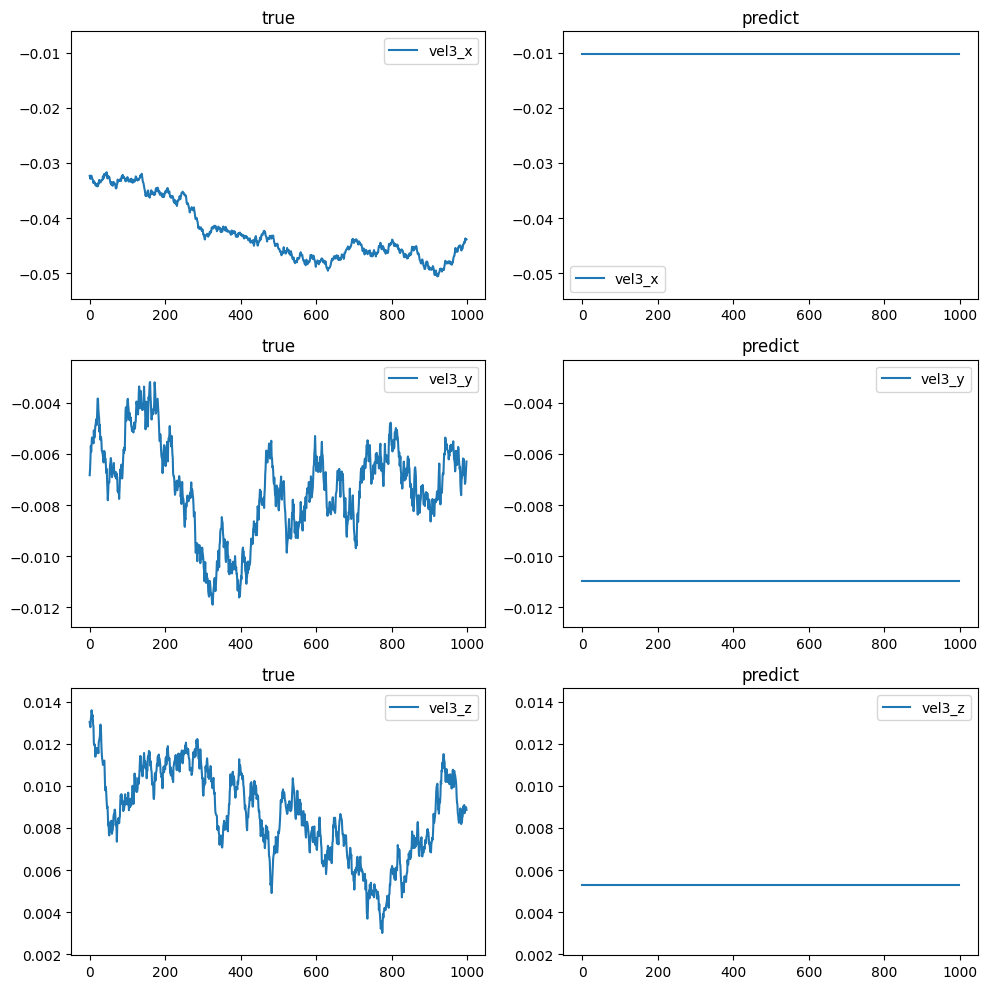

In [33]:

# i = 200
i = len(true_)

nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))

for j, sym in enumerate(['x','y','z']):
    true_values = [x[-1][j] for x in true_[:i]]
    pre_values = [x[-1][j] for x in pre_[:i]]
    min_, max_ = min(min(true_values), min(pre_values)), max(max(true_values), max(pre_values))
    gap = (max_-min_)/10
    min_, max_ = min_-gap, max_+gap
    
    ax = axes[j][0]
    ax.set_title('true')
    ax.plot(range(i), true_values, label=f'{args.predict_column}_{sym}')
    ax.legend()
    ax.set_ylim([min_, max_])

    ax = axes[j][1]
    ax.set_title('predict')
    ax.plot(range(i), pre_values, label=f'{args.predict_column}_{sym}')
    ax.legend()
    ax.set_ylim([min_, max_])
plt.tight_layout()
    